Download the dataset from Kaggle. Add your `kaggle.json` API key to the project root from [Kaggle settings](https://www.kaggle.com/settings) so that `asl.ipynb` and `kaggle.json` are in the same directory. 

In [1]:
%pip install opendatasets nbstripout pandas numpy pillow matplotlib scikit-learn notebook seaborn "tensorflow[and-cuda]" --upgrade --quiet
# strips out notebook output for commits
# !nbstripout --install --attributes .gitattributes

# install RAPIDS nightly packages to accelerate scikit-learn via CUDA
!(pip install \
    --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
    "cudf-cu12>=24.10.0a0,<=24.10" "dask-cudf-cu12>=24.10.0a0,<=24.10" \
    "cuml-cu12>=24.10.0a0,<=24.10" "cugraph-cu12>=24.10.0a0,<=24.10" \
    "cuspatial-cu12>=24.10.0a0,<=24.10" "cuproj-cu12>=24.10.0a0,<=24.10" \
    "cuxfilter-cu12>=24.10.0a0,<=24.10" "cucim-cu12>=24.10.0a0,<=24.10" \
    "pylibraft-cu12>=24.10.0a0,<=24.10" "raft-dask-cu12>=24.10.0a0,<=24.10" \
    "cuvs-cu12>=24.10.0a0,<=24.10" "pylibraft-cu12>=24.10.0a0,<=24.10" \
    "nx-cugraph-cu12>=24.10.0a0,<=24.10" "dask-cuda>=24.10.0a0,<=24.10" --quiet)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.0a401 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
dask-cudf-cu12 24.10.0a401 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
import cupy as cp
import opendatasets as od

# define a random state for testing
randomstate = 13
rng = cp.random.RandomState(randomstate)

dataset = 'https://www.kaggle.com/datasets/grassknoted/asl-alphabet'
od.download(dataset)
training_set_files = glob.glob("./asl-alphabet/asl_alphabet_train/asl_alphabet_train/*/*.jpg")

Skipping, found downloaded files in "./asl-alphabet" (use force=True to force download)


In [3]:
import numpy as np
from PIL import Image
import cudf
from cuml.model_selection import train_test_split
from cuml.preprocessing import LabelEncoder
import os
import concurrent.futures

# resolution to scale to
res = (50, 50)
X, y = [], []

def process_file(file):
    # the foldername tells the character
    label = os.path.basename(os.path.dirname(file))
    if label in ["del", "nothing", "space"]:
        return None, None
    img = Image.open(file)
    img_r = img.resize(res)
    
    # convert to grayscale
    img_bw = np.array(img_r.convert("L"))

    # generate a flat array of the image
    img_flat = img_bw.flatten()

    return img_flat, label

# multithreaded processing to speed up by around a factor of 4 on my machine
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(process_file, training_set_files))

for img_flat, label in results:
    if img_flat is not None and label is not None:
        X.append(img_flat)
        y.append(label)

# convert to cudf.DataFrame in order 
X_a = cudf.DataFrame(np.array(X))
y_a = np.array(y)

# encode labels to integers for cuML
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_a)

# split into 80-10-10
X_train, X_val, y_train, y_val = train_test_split(X_a, y_encoded, train_size=0.8, random_state=rng)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, train_size=0.5, random_state=rng)

print(len(X_train), len(X_val), len(X_test), len(y_train), len(y_val), len(y_test))

62400 7800 7800 62400 7800 7800


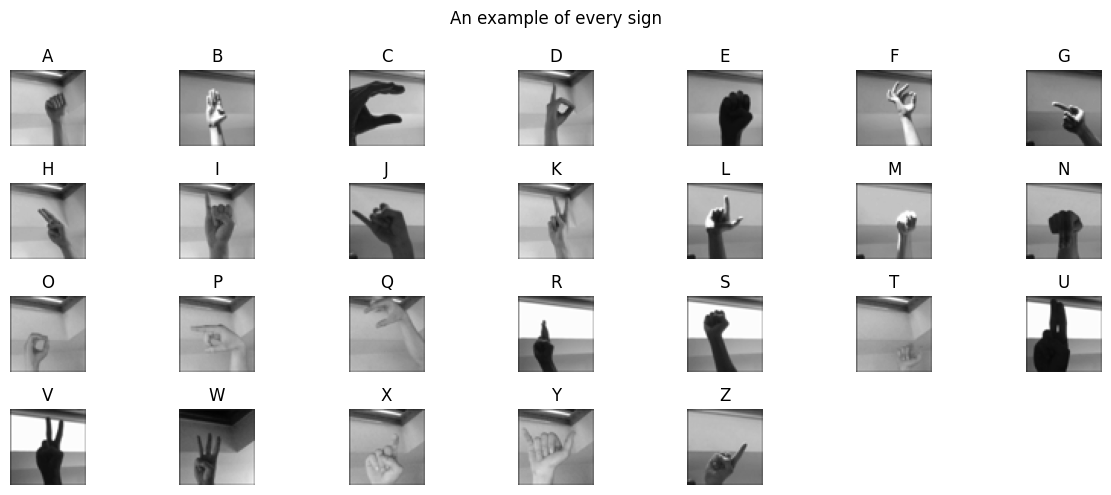

In [4]:
import matplotlib.pyplot as plt

def plot_signs(X_signs, y_labels, title):
    # plot an example of every sign (from "A" to "Z")
    unique_labels = sorted(set(y_labels))
    fig, axes = plt.subplots(4, 7, figsize=(12, 5))
    axes = axes.flatten()

    for ax, label in zip(axes, unique_labels):
        idx = np.where(y_labels == label)[0][0]
        img = X_signs[idx].reshape(res)
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        if type(label) == np.uint8:
            label = label_encoder.inverse_transform([label])[0]
        ax.set_title(label)
        ax.axis('off')

    # remove extra empty plots
    for ax in axes[len(unique_labels):]:
        fig.delaxes(ax)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# plot X and y
plot_signs(X_a.to_pandas().values, y_a, "An example of every sign")

[W] [21:19:35.309351] L-BFGS: max iterations reached
[W] [21:19:35.309992] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


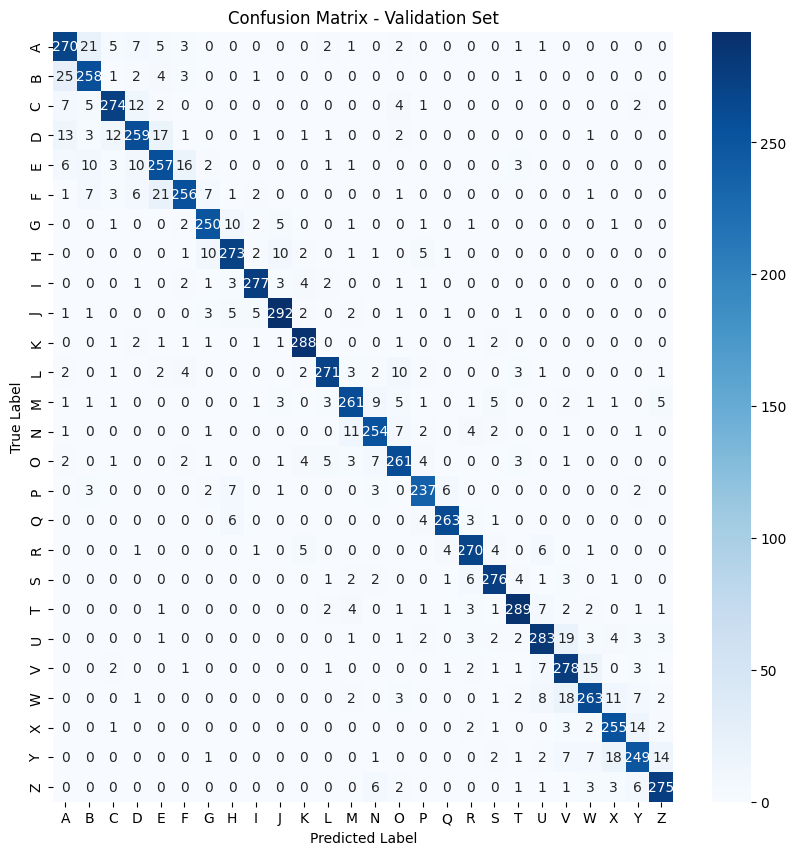

Prediction accuracy: 88.96%


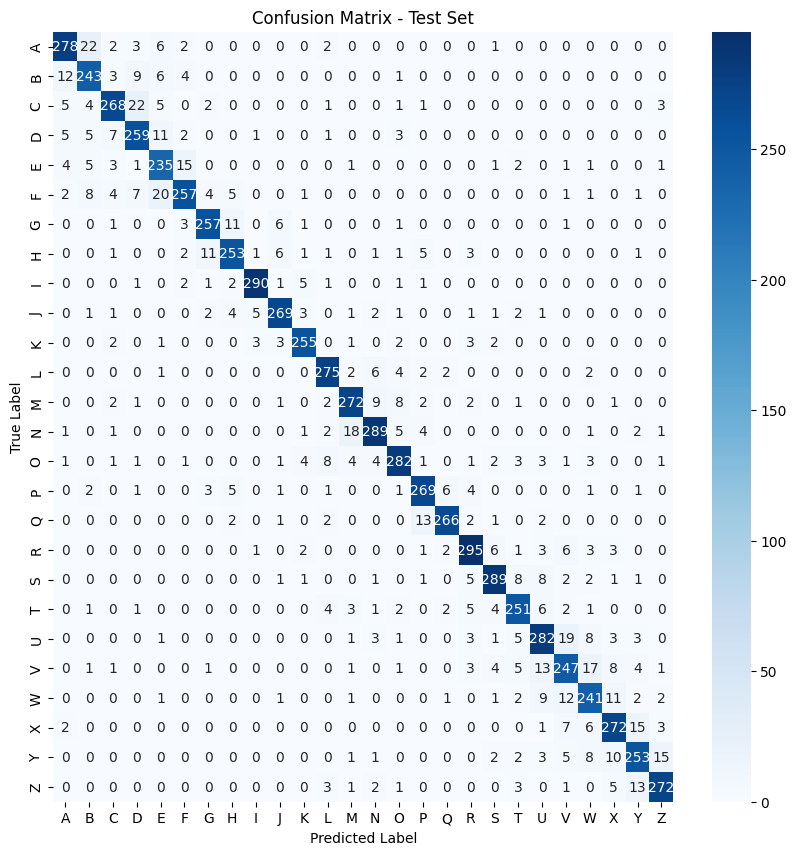

Test set prediction accuracy: 88.71%
Log loss: 0.4944


In [5]:
from cuml.linear_model import LogisticRegression
from cuml.metrics import accuracy_score, confusion_matrix, log_loss
import seaborn as sns

clf = LogisticRegression(max_iter=10000) # default 1000, this doesn't have random_state :(
clf.fit(X_train, y_train)

def generate_confusion_matrix(y_true, y_pred, title):
    # make the labels the letters for numbers
    cm = confusion_matrix(y_true, y_pred, convert_dtype=True)

    # convert to numpy for seaborn
    cm_np = cp.asnumpy(cm)
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_np,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.inverse_transform(np.arange(26)).to_arrow().to_pylist(),
        yticklabels=label_encoder.inverse_transform(np.arange(26)).to_arrow().to_pylist(),
    )
    ax = plt.gca()

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - " + title)

y_pred = clf.predict(X_val)

generate_confusion_matrix(y_val, y_pred, "Validation Set")
plt.show()

# compute the accuracy
multi_accuracy = accuracy_score(y_val, y_pred)
print(f"Prediction accuracy: {100*multi_accuracy:.2f}%")

# default iters (1000) 76.85%, around 10s
# 10k iters 88.71%, around 1m20s
# step delta flattens out around 1min46s, 88.54%

# test set accuracy
y_pred_test = clf.predict(X_test)
y_test = y_test
y_pred_test = y_pred_test

generate_confusion_matrix(y_test, y_pred_test, "Test Set")
plt.show()

multi_accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test set prediction accuracy: {100*multi_accuracy_test:.2f}%")

y_test32 = y_test.astype("int32")
# loss
y_pred_proba = clf.predict_proba(X_test)
multi_log_loss = log_loss(y_test32, y_pred_proba)
print(f"Log loss: {multi_log_loss:.4f}")

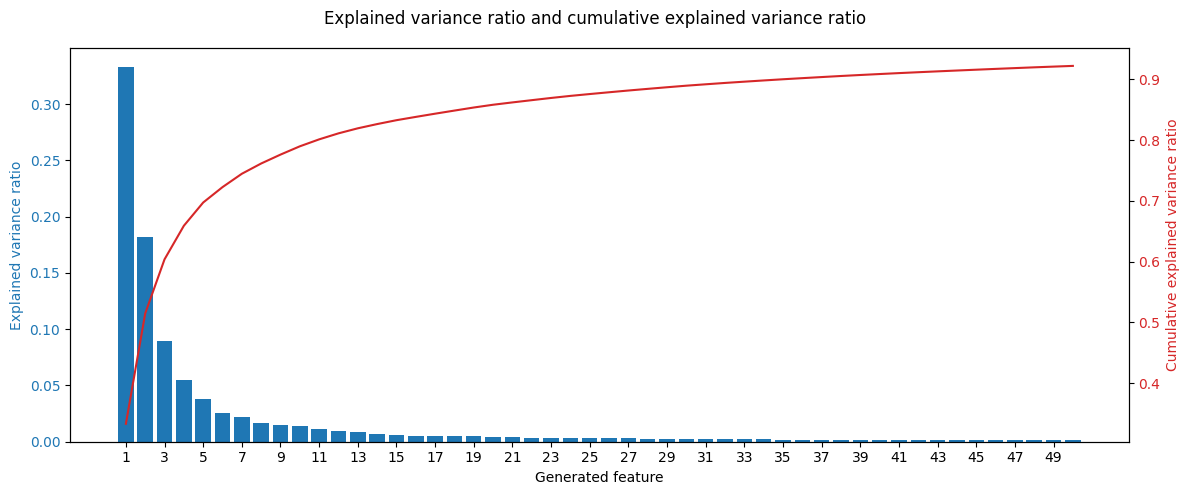

In [15]:
from cuml.decomposition import PCA

N = 50
pca = PCA(n_components=N)
X_train_reduced = pca.fit_transform(X_train)

explained_variance_ratio = pca.explained_variance_ratio_.to_numpy()

# plot the explained variances
fig, ax1 = plt.subplots(figsize=(12, 5))
fig.suptitle("Explained variance ratio and cumulative explained variance ratio")
color = "tab:blue"
ax1.bar(1 + np.arange(N), explained_variance_ratio, color=color)
ax1.set_xticks(1 + np.arange(N, step=2))
ax1.tick_params(axis="y", labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = "tab:red"
ax2.tick_params(axis="y", labelcolor=color)
ax2.plot(1 + np.arange(N), np.cumsum(explained_variance_ratio), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.show()

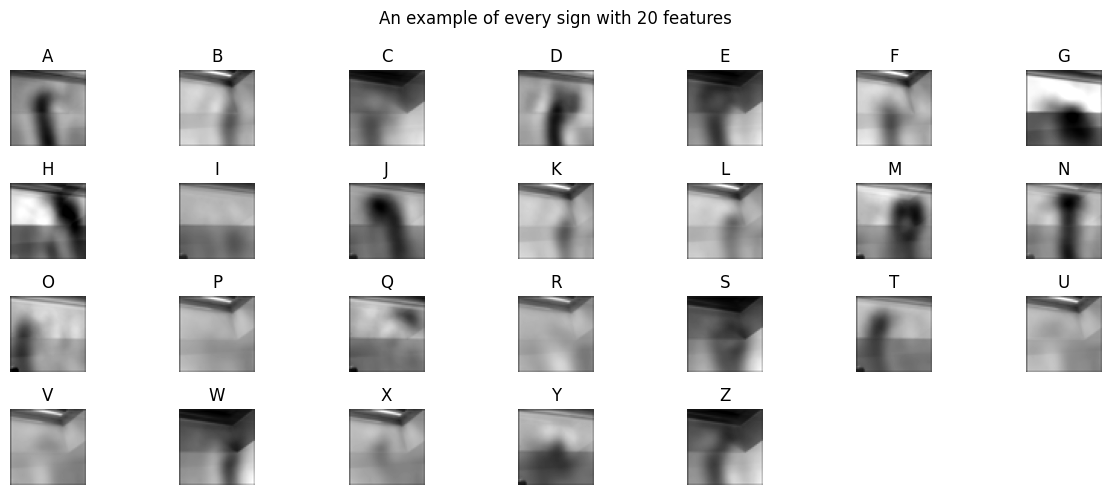

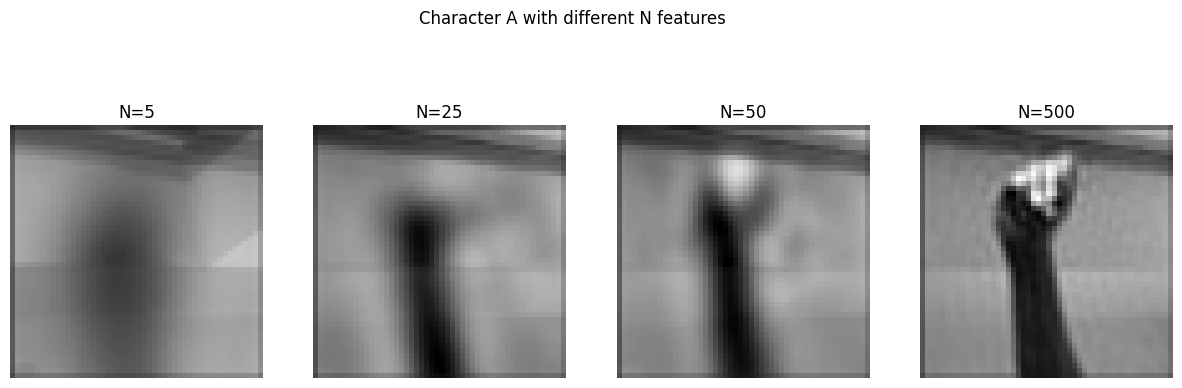

In [7]:
# reduce the data to N features
def reduce_to(N):
    pca.set_params(n_components=N)
    X_train_reduced = pca.fit_transform(X_train)
    X_val_reduced = pca.transform(X_val)
    X_test_reduced = pca.transform(X_test)
    
    return X_train_reduced, X_val_reduced, X_test_reduced

X_train_reduced, X_val_reduced, X_test_reduced = reduce_to(20)

X_train_reduced_cupy = cp.asnumpy(X_train_reduced.to_cupy())
y_train_np = cp.asnumpy(y_train.to_cupy())

plot_signs(
    pca.inverse_transform(X_train_reduced_cupy),
    y_train_np,
    "An example of every sign with 20 features",
)
plt.show()

# plot a certain character with different values of N
def plot_character_reduced(character, N_values):
    fig, axes = plt.subplots(1, len(N_values), figsize=(15, 5))
    for ax, N in zip(axes, N_values):
        pca.set_params(n_components=N)
        X_train_reduced = pca.fit_transform(X_train)
        X_train_reduced_cupy = cp.asnumpy(X_train_reduced.to_cupy())

        # get the first example of the character
        idx = np.where(y_train_np == character)[0][0]
        img = pca.inverse_transform(X_train_reduced_cupy[idx: idx + 1])

        ax.imshow(img.reshape(res), cmap="gray", vmin=0, vmax=255)
        ax.set_title(f"N={N}")
        ax.axis("off")

    fig.suptitle(f"Character {label_encoder.inverse_transform([character])[0]} with different N features")
    plt.show()

plot_character_reduced(0, [5, 25, 50, 500])

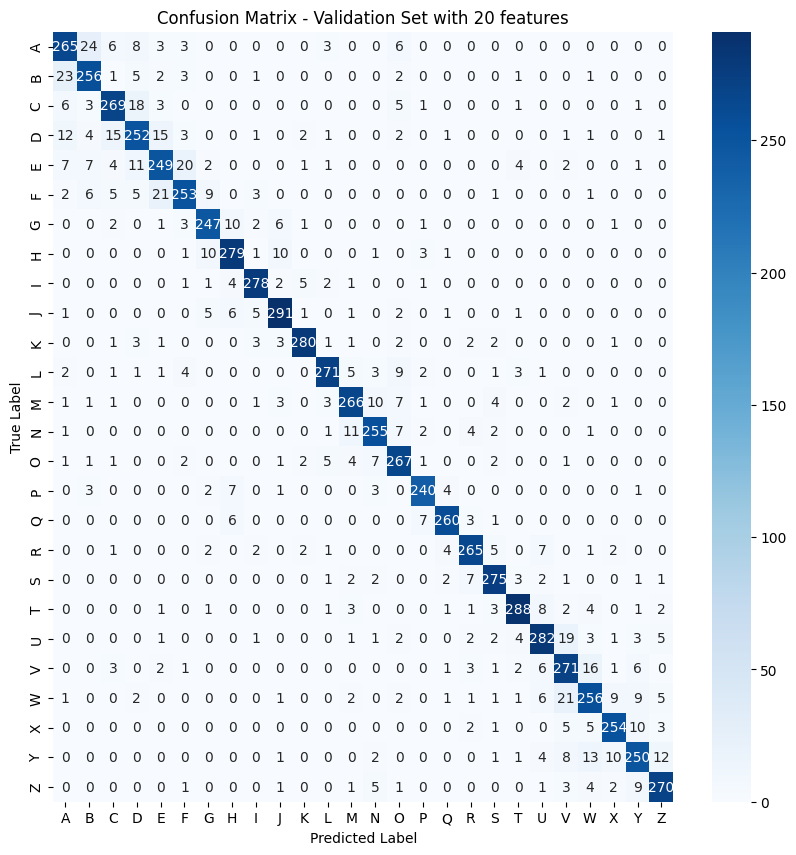

Prediction accuracy: 88.32%


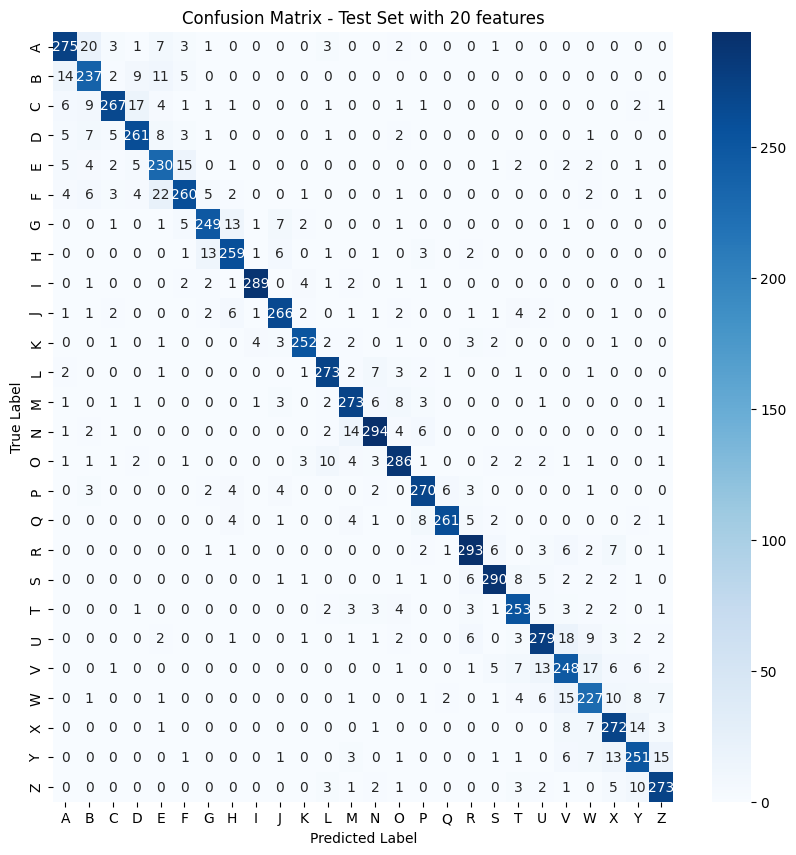

Test set prediction accuracy: 88.31%
[W] [21:49:38.041224] L-BFGS line search failed (code 3); stopping at the last valid step
[W] [21:49:42.494724] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
[W] [21:49:57.688524] L-BFGS line search failed (code 3); stopping at the last valid step
[W] [21:51:03.485968] L-BFGS: max iterations reached
[W] [21:51:03.486786] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


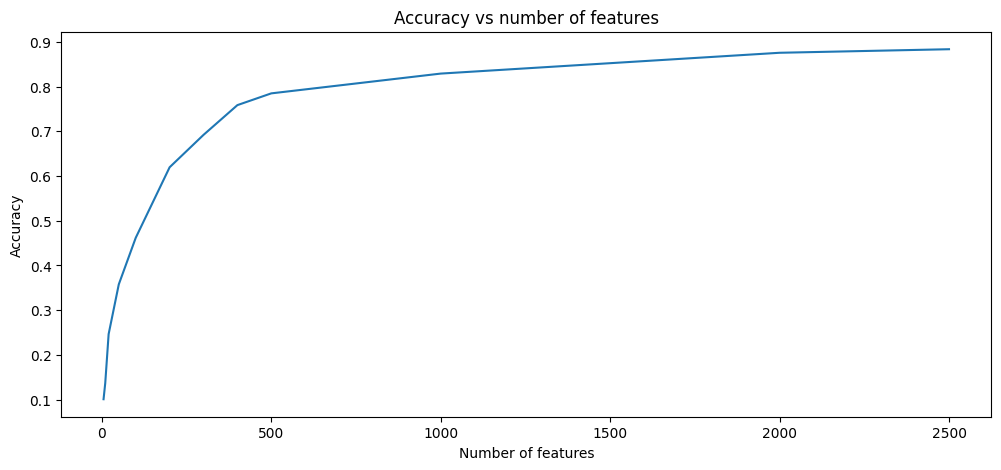

In [14]:
# let's try with the reduced data

clf = LogisticRegression(max_iter=10000)
clf.fit(X_train_reduced, y_train)

y_pred = clf.predict(X_val_reduced)

generate_confusion_matrix(y_val, y_pred, "Validation Set with 20 features")
plt.show()

# compute the accuracy
multi_accuracy = accuracy_score(y_val, y_pred)
print(f"Prediction accuracy: {100*multi_accuracy:.2f}%")

# test set accuracy
y_pred_test = clf.predict(X_test_reduced)

generate_confusion_matrix(y_test, y_pred_test, "Test Set with 20 features")
plt.show()

multi_accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test set prediction accuracy: {100*multi_accuracy_test:.2f}%")

# plot a graph of the accuracy vs the number of features
N_values = [5, 10, 20, 50, 100, 200, 300, 400, 500, 1000, 2000, 2500]
accuracies = []

for N in N_values:
    X_train_reduced, X_val_reduced, X_test_reduced = reduce_to(N)
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_val_reduced)
    accuracies.append(accuracy_score(y_val, y_pred))

plt.figure(figsize=(12, 5))
plt.plot(N_values, accuracies)
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs number of features")
plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# reshape the flattened images back to (50, 50, 1) to represent grayscale images
X_reshaped = np.array(X).reshape(-1, res[0], res[1], 1)  # add the channel dimension for grayscale images
y_int = label_encoder.fit_transform(y)  # converts labels 'A', 'B', ... to numerical format

model = Sequential(
    [
        layers.Rescaling(
            1.0 / 255, input_shape=(res[0], res[1], 1)
        ),  # grayscale input (1 channel)
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(26),  # 26 classes for the letters of the alphabet
    ]
)
model.summary()

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

X_train_np = X_train.to_numpy().reshape(-1, res[0], res[1], 1)
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy().reshape(-1, res[0], res[1], 1)
y_val_np = y_val.to_numpy()

# fit the model
epochs = 20
history = model.fit(
    X_train_np,
    y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=epochs,
)

/home/ubuntu/rojekteja/CS-C3240-Project/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,690 (1.23 MB)

 Trainable params: 321,690 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4536 - loss: 1.7997 - val_accuracy: 0.9054 - val_loss: 0.2888
Epoch 2/20
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9287 - loss: 0.2200 - val_accuracy: 0.9394 - val_loss: 0.1704
Epoch 3/20
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9629 - loss: 0.1113 - val_accuracy: 0.9376 - val_loss: 0.1975
Epoch 4/20
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9734 - loss: 0.0856 - val_accuracy: 0.9841 - val_loss: 0.0458
Epoch 5/20
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9821 - loss: 0.0596 - val_accuracy: 0.9846 - val_loss: 0.0492
Epoch 6/20
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9881 - loss: 0.0397 - val_accuracy: 0.9879 - val_loss: 0.0374
Epoch 7/20
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9875 - loss: 0.0412 - val_accuracy: 0.9638 - val_loss: 0.1221
Epoch 8/20
1950/1950 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9900 - loss: 0.0319 - 

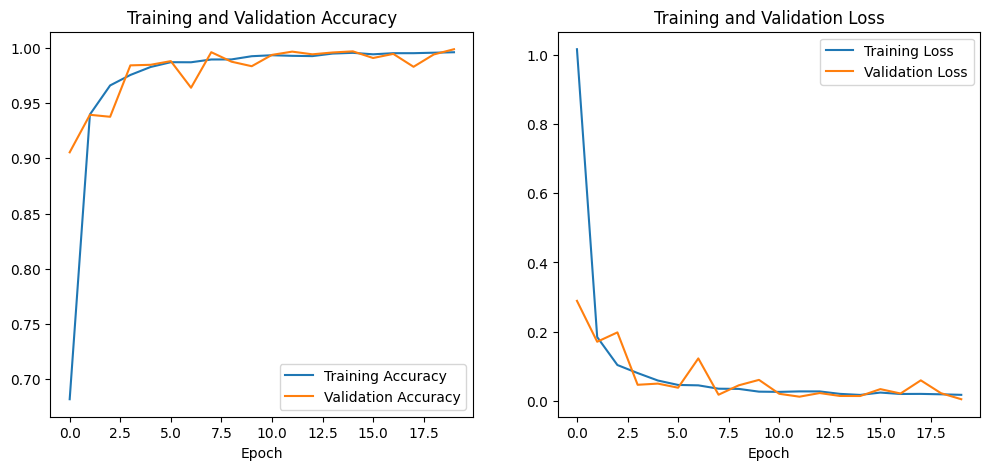

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9978 - loss: 0.0076
Test accuracy: 0.9980769157409668
Test loss: 0.0057694921270012856


In [13]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")

plt.show()

X_test_np = X_test.to_numpy().reshape(-1, res[0], res[1], 1)
y_test_np = y_test.to_numpy()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_np, y_test_np)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")